#Overview

Today we're investigating how subway ridership is affected by incidence of rain. I've taken a sample of MTA New York City Subway dataset from May, 2011 containing hourly entries and exits to turnstiles (UNIT) by day in the subway system. Joined with this dataset is weather data from Weather Underground containing features such as barometric pressure, wind speed, temperature, the total amount of precipitation, and the indicidence of rain, fog, and thunder.

The CSV is loaded into a Pandas dataframe named turnstile_master. Here's a preview of the first five rows:

In [1]:
%matplotlib inline
import pandas as pd

turnstile_master = pd.read_csv('turnstile_data_master_with_weather.csv')
turnstile_master.head()

,Unnamed: 0,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,0,R001,2011-05-01,01:00:00,1,REGULAR,0,0,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
1,1,R001,2011-05-01,05:00:00,5,REGULAR,217,553,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
2,2,R001,2011-05-01,09:00:00,9,REGULAR,890,1262,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
3,3,R001,2011-05-01,13:00:00,13,REGULAR,2451,3708,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
4,4,R001,2011-05-01,17:00:00,17,REGULAR,4400,2501,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0


#Section 1: Statistical Test

##1.1 Methodology
I performed a Mann-Whitney U-test to find the U-statistic and p-value by comparing the number of turnstile entries with rain and without rain. A two-tail p-value was used with no assumptions made about the distributions of ridership on rainy and non-rainy days.

The p-value returned by scipy.stats.mannwhitneyu is one-tailed as noted here:

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

To perform the two-tailed test, the one-tailed p-value returned by scipy.stats.mannwhitneyu is multiplied by 2.

The p-critical value used in this test is 0.05 to test for significance (i.e. 5% chance of observing a result as least as extreme).

##1.2 Applicability
We're ultimately trying to determine whether subway ridership varies with weather. We start by split the hourly entries into two samples, entries with and without rain.

The Mann-Whitney U-Test tests the null hypothesis that the two samples being compared are derived from the same population. This null hypothesis allows us to test whether there is a statistically significant difference in distributions of ridership on rainy and non-rainy days (and thus, the hourly entries derived from the same population).

Exploratory data analysis (Section 3.1) indicates that the data is not normally distributed. The Mann-Whitney U-Test makes no assumptions about the normality of the data, validating that this test is appropriate.

##1.3 Results
Here's what we got from the Mann-Whitney U-Test:

In [2]:
import numpy as np

with_rain = turnstile_master[turnstile_master.rain == 1]['ENTRIESn_hourly']
with_rain_mean = np.mean(with_rain)

without_rain = turnstile_master[turnstile_master.rain == 0]['ENTRIESn_hourly']
without_rain_mean = np.mean(without_rain)

print "Mean entries, with rain: {0}\nMean entries, without rain: {1}".format(with_rain_mean, without_rain_mean)

Mean entries, with rain: 1105.44637675
Mean entries, without rain: 1090.27878015


In [3]:
import scipy
import scipy.stats

[U, p] = scipy.stats.mannwhitneyu(with_rain, without_rain)

print "Mann-Whitney Test Statistic: {0}\np-Value: {1}".format(U, p)

Mann-Whitney Test Statistic: 1924409167.0
p-Value: 0.0249999127935


##1.4 Significance

In [4]:
# Significance level defined in Section 1.1
alpha = 0.05

# two-tailed test
if (p * 2) < alpha:
    print 'Reject the null hypothesis: {0} < {1}'.format(p * 2, alpha)
else:
    print 'Fail to reject null hypothesis: {0} < {1}'.format(p * 2, alpha)

Reject the null hypothesis: 0.049999825587 < 0.05


The p-value barely didn't meet our two-tailed significance threshold of 5%, so we reject the null hypothesis of the Mann-Whitney U-Test. We conclude that the distribution of the entries is statistically different between rainy and non-rainy days.

#Section 2: Linear Regression

##2.1 Predicting Ridership with Gradient Descent
Linear Regression with Gradient descent was performed using SciPy.

We want to choose a θ with an initial guess vector of 0 values so as to minimize J(θ). Gradient descent is used as a search algorithm that repeatedly changes θ to make J(θ) smaller, until hopefully we converge to a value of θ that minimizes J(θ).

Refer to the Machine Learning course taught at Stanford by Andrew Ng for more information on gradient descent:
http://cs229.stanford.edu/notes/cs229-notes1.pdf

##2.2 Feature Selection
The following features are taken directly from the turnstile_master dataset:
- rain
- precipitation
- hour
- mean temperature

In [5]:
# Select Features
features = turnstile_master[['rain', 'precipi', 'Hour', 'meantempi']]

The dummy variable (UNIT) taken directly from the turnstile_master dataset is used as categorical features for our linear model.

In [6]:
# Add UNIT to features using dummy variables
dummy_units = pd.get_dummies(turnstile_master['UNIT'], prefix='unit')
features = features.join(dummy_units)

##2.3 Feature Selection Rationale
meantempi is chosen as a feature as temperature is a component of the weather that affects people’s decision making. A given temperature may affect how long and how much effort it takes to clothe in the morning. A person may simply choose to stay indoors due to discomfort with a given temperature.

Hour and weekday features were chosen as it is easily observed how ridership varies with time of day and day of week. A phenomenon supporting the Hour feature is the daily rush hours that mass transit systems and roadways exhibit and accommodate. An observation supporting the use of weekday is how the MTA train schedule varies between weekdays and weekends, with trains arriving with more infrequency on Saturday and Sunday.

##2.4 Model Results

Lets start by normalizing the features in the dataset.

In [7]:
# Values
values = turnstile_master['ENTRIESn_hourly']
m = len(values)

# Normalize the features in the dataset.
mu = features.mean()
sigma = features.std()

if (sigma == 0).any():
    raise Exception("One or more features had the same value for all samples, and thus could " + \
                     "not be normalized. Please do not include features with only a single value " + \
                     "in your model.")
features = (features - mu) / sigma

# Add a column of 1s (y intercept)
features['ones'] = np.ones(m)

Prepare features and output value arrays, learning rate alpha, parameters theta, and num_iteration values for gradient descent.

We set the intitial coefficient vector theta to a column vector of zeros. 

In [8]:
# Convert features and values to numpy arrays
features_array = np.array(features)
values_array = np.array(values)

# Set values for alpha, number of iterations.
alpha = 0.1
num_iterations = 75

# Initialize theta for gradient descent
theta_gradient_descent = np.zeros(len(features.columns))

Finally perform gradient descent, building a cost history over time. During this process, the cost function recomputes the theta value for a given number of iterations as a numerical approach to approximating the ideal coefficients to fit the linear regression model.

In [9]:
# Perform gradient descent given a data set with an arbitrary number of features.
cost_history = []

for i in range(num_iterations):
    predicted_value = np.dot(features_array, theta_gradient_descent)
    theta_gradient_descent = theta_gradient_descent + alpha/m * np.dot(values_array - predicted_value, features_array)

    # Compute the cost function given a set of features / values, and the values for our thetas.
    sum_of_square_errors = np.square(np.dot(features_array, theta_gradient_descent) - values_array).sum()
    cost = sum_of_square_errors / (2 * m)
    
    # Add cost to history
    cost_history.append(cost)
    
cost_history = pd.Series(cost_history)

# Calculate predictions
predictions = np.dot(features_array, theta_gradient_descent)

Let's visualize this.

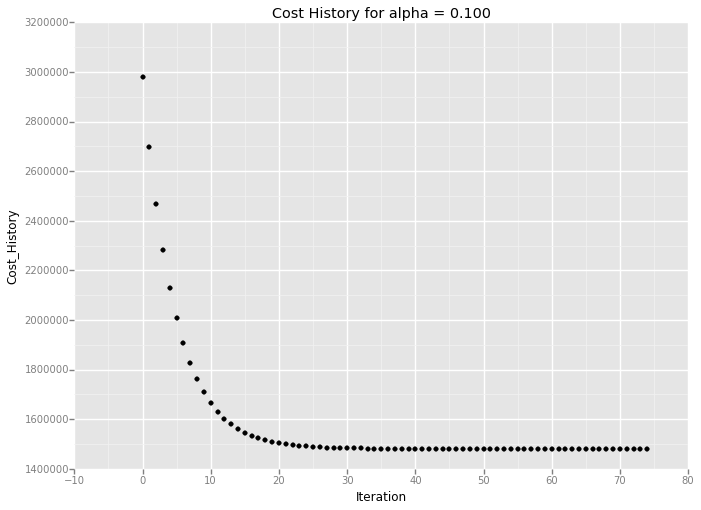

<ggplot: (347426297)>

In [10]:
from ggplot import *

# Plot cost history for viewing.
cost_df = pd.DataFrame({
  'Cost_History': cost_history,
  'Iteration': range(len(cost_history))
})

ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
  geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha )


##2.5 Goodness of Fit
After making predictions, use the coefficient of determination (R^2) to see how the model performed:

In [11]:
# Compute the coefficient of determination (R^2) given
# a list of original data points and a list of predicted data points
sq_data_predictions_diff = np.sum((values - predictions)**2)
mean = np.mean(values)
sq_data_mean_diff = np.sum((values - mean)**2)

r_squared = 1 - sq_data_predictions_diff / sq_data_mean_diff

print "Calculated R^2 value: {0}".format(r_squared)

Calculated R^2 value: 0.458044314039


This R^2 value is is rather low, indicating that linear regression model doesn't fit with the data too well. Perhaps linear models aren't the best models for this dataset since the histogram of hourly entries shows a more normal distribution. Thus, I would expect the R2 value to be low. Due to the categorical nature of data, ('rain', 'no rain') a linear model inappropriate.

#Section 3. Visualization
##3.1 Distribution of ENTRIESn_hourly

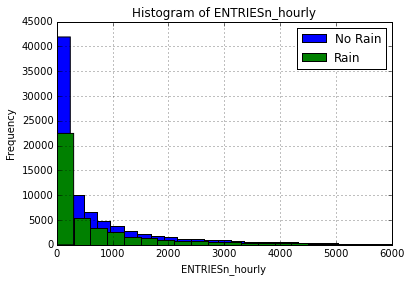

In [12]:
import matplotlib.pyplot as plt

plt.figure()

# your code here to plot a historgram for hourly entries when it is not raining
non_rainy_data = turnstile_master[turnstile_master['rain'] == 0]['ENTRIESn_hourly']
non_rainy_data.hist(range = [0, 6000], bins = 25, label='No Rain')

# your code here to plot a historgram for hourly entries when it is raining
rainy_data = turnstile_master[turnstile_master['rain'] == 1]['ENTRIESn_hourly']
rainy_data.hist(range = [0, 6000], bins = 20, label='Rain')

plt.title('Histogram of ENTRIESn_hourly')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')
plt.legend()

plt.figure()

The distribution of ENTRIESn_hourly appears to not be normally distributed and skewed to the right on both rainy and non-rainy days. The mode appears to be within the smallest bin for both distributions. There are far fewer observations on rainy days than non-rainy days.

##3.2 Average Hourly Ridership by Hour of Day

/Users/James/anaconda/lib/python2.7/site-packages/pandasql/sqldf.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.float)


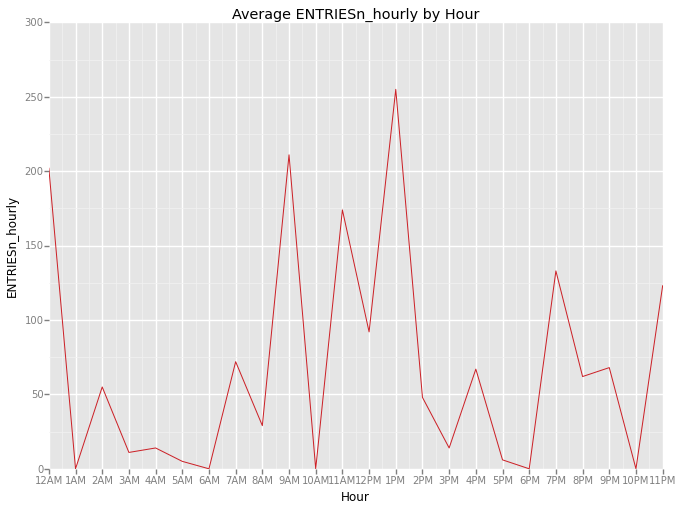

<ggplot: (281690245)>


In [13]:
import pandasql

df = turnstile_master[['Hour', 'ENTRIESn_hourly']]

q = """
    SELECT Hour AS hour,
           ENTRIESn_hourly AS hourlyentries
    FROM df
    GROUP BY hour
    """

#Execute SQL command against the pandas frame
rainy_days = pandasql.sqldf(q.lower(), locals())

print ggplot(rainy_days, aes('hour', 'hourlyentries')) + \
             geom_path(color='#cc2127') + \
             scale_x_continuous(name='Hour',
                                breaks=[0, 1, 2, 3, 4, 5,
                                        6, 7, 8, 9, 10, 11,
                                        12, 13, 14, 15, 16, 17,
                                        18, 19, 20, 21, 22, 23],
                                labels=['12AM', '1AM', '2AM', '3AM', '4AM', '5AM',
                                        '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
                                        '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
                                        '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']) + \
             ggtitle('Average ENTRIESn_hourly by Hour') + \
             xlab('Hour') + \
             ylab('ENTRIESn_hourly') + \
             xlim(0, 23)

The above bar chart shows the average hourly ridership by hour of day. The line plot shows high ridership aligned with commute times to and from work, along with lunch hours and approaching midnight.

##3.3 Average Hourly Ridership by Day of Week

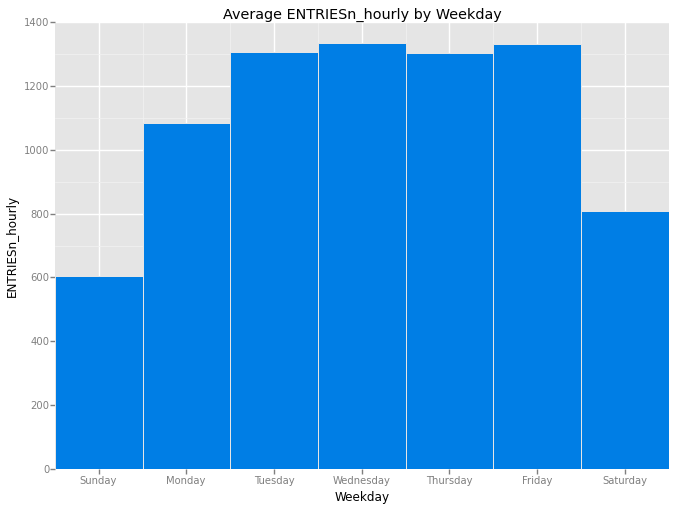

<ggplot: (347427845)>


In [14]:
df = turnstile_master[['DATEn', 'ENTRIESn_hourly']]

q = """
    SELECT cast(strftime('%w', DATEn) AS integer) AS weekday,
           sum(ENTRIESn_hourly)/count(*) AS hourlyentries
    FROM df
    GROUP BY cast(strftime('%w', DATEn) AS integer)
    """

#Execute SQL command against the pandas frame
rainy_days = pandasql.sqldf(q.lower(), locals())

print ggplot(rainy_days, aes('weekday', 'hourlyentries')) + \
        geom_bar(fill = '#007ee5', stat='bar') + \
        scale_x_continuous(name='Weekday',
                           breaks=[0, 1, 2, 3, 4, 5, 6],
                           labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday',
                                   'Thursday', 'Friday', 'Saturday']) + \
        ggtitle('Average ENTRIESn_hourly by Weekday') + \
        ylab('ENTRIESn_hourly') + \
        xlim(-.5, 6.5)

The above bar chart shows the average hourly ridership by day of week. The sum of ENTRIESn_hourly by day of week was divided by the count of rows for a given day of week (as each row represents an hour’s worth of data).

The bar chart shows that a higher average hourly ridership on weekdays than weekends, with Saturday seeing significantly higher ridership than Sunday.

Monday's average hourly ridership is notably different than the rest of the weekdays, perhaps  due to a seasonal effect of Monday holidays. The given data set is a sample from May 2011 and there's at least one major holiday that falls on Monday in the month of May: Memorial Day.

#Section 4: Conclusion

##4.1 Do More People Ride the Subway When it is Raining?
Based on this analysis, I'm confident that more people ride the NYC subway when it is raining.

##4.2 Rationale
As seen in Section 1.3, the mean of ENTRIESn_hourly is greater for hours with rain than without (1,105 vs. 1,090).

Additionally, the Mann-Whitney U-Test indicates that the ENTRIESn_hourly sample with rain appears to be drawn from a different distribution (or population) than the ENTRIESn_hourly sample from hours without rain.

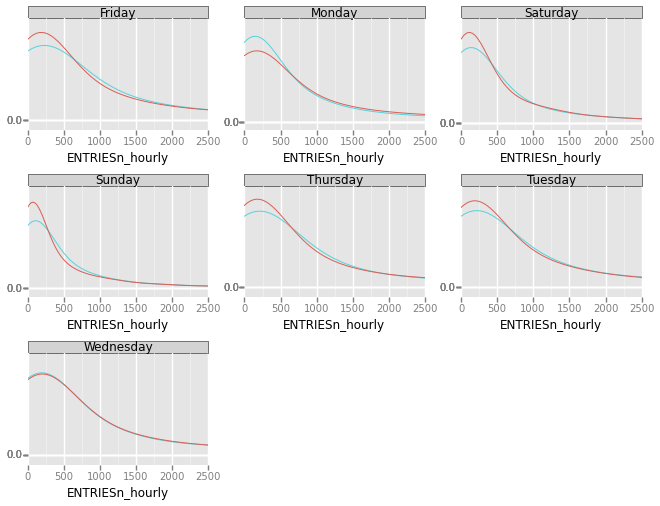

<ggplot: (345798425)>


In [15]:
from datetime import datetime

df = turnstile_master[['DATEn', 'ENTRIESn_hourly', 'rain']]
df.is_copy = False

# get the weekday as a string
f = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%A') 

df['weekday'] = df['DATEn'].apply(f)

print ggplot(aes(x='ENTRIESn_hourly', color='rain'), data = df) \
        + geom_density() \
        + xlim(0,2500) \
        + facet_wrap('weekday')

This faceted grid shows the density functions of ENTRIESn_hourly with and without rain for each day of the week. Currently legends do not work within ggplot facets. Red represents without rain, and blue represents with rain. It appears for every day, except Monday, that the distribution of ENTRIESn_hourly has a fatter right tail when there is rain.

#Section 5: Reflection

##5.1 Shortcomings of the Data Set and Methods of Analysis
We're only working with a single month of MTA data, which is subject to effects of seasonality, as the time of year may also affect ridership. Additionally, this month contains a Monday holiday, which is reflected in the visualizations in Section 3.2 and Section 4.

The biggest shortcoming with this dataset is the discrepency between the units of the two joined datasets. The MTA turnstile entry data is produced on an hourly basis, whereas the weather data is produced daily. When it rains at any point in a given day, every hour of that day will reflect that it rained. This prevents a truly granular analysis of how the weather can affect ridership within a day.